In [80]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
os.getcwd()
os.chdir(os.getcwd())


Read 4 json files and transform them into DataFrames, then concat into 1 final DataFrame (df)

In [82]:
df_part_1 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2020-2023_0.json")
df_part_2 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2023_1.json")
df_part_3 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2023-2024_2.json")
# df_part_4 = pd.read_json("Spotify Extended Streaming History\Streaming_History_Video_2020-2024.json")

In [83]:
# Concat all given DataFrames into 1 DF for further analyses
spotify_df = pd.concat([df_part_1, df_part_2, df_part_3])
# Removing username column because I am the only one using this account
spotify_df.drop(columns=['username'], inplace=True)

In [84]:
spotify_df.head()

,ts,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2020-08-22T16:34:56Z,Windows 10 (10.0.18363; x64; AppX),238360,VN,171.241.150.149,unknown,unravel,TK from Ling tosite sigure,Fantastic Magic,spotify:track:0GLyqTysS0DFoeKjURtB8s,None,None,None,clickrow,trackdone,False,NaN,False,1598113859206,False
1,2020-08-22T16:40:32Z,Windows 10 (10.0.18363; x64; AppX),9490,VN,171.241.150.149,unknown,katharsis,TK from Ling tosite sigure,Katharsis,spotify:track:0PnrdoLqdpScsUTYd06Zb8,None,None,None,trackdone,logout,False,NaN,False,1598114096805,False
2,2020-08-22T16:40:42Z,Windows 10 (10.0.18363; x64; AppX),2500,VN,171.241.150.149,unknown,Dancing With A Stranger (with Normani),Sam Smith,Dancing With A Stranger (with Normani),spotify:track:6Qs4SXO9dwPj5GKvVOv8Ki,None,None,None,clickrow,endplay,False,NaN,False,1598114439494,False
3,2020-08-22T16:40:45Z,Windows 10 (10.0.18363; x64; AppX),3100,VN,171.241.150.149,unknown,How Do You Sleep?,Sam Smith,How Do You Sleep?,spotify:track:6b2RcmUt1g9N9mQ3CbjX2Y,None,None,None,clickrow,endplay,False,NaN,False,1598114442297,False
4,2020-08-22T16:40:52Z,Windows 10 (10.0.18363; x64; AppX),6580,VN,171.241.150.149,unknown,Too Good At Goodbyes,Sam Smith,The Thrill Of It All,spotify:track:1mXVgsBdtIVeCLJnSnmtdV,None,None,None,clickrow,endplay,False,NaN,False,1598114445537,False


In [85]:
music_df = spotify_df.drop(columns=['episode_name', 'episode_show_name', 'spotify_episode_uri'],inplace=False)
# Using the Music DF to only concern about music listened during my usage of Spotify from 2020 upto now

### Descriptive statistics of listening habit

In [86]:
print("Total tracks listened:", len(music_df))
print("Number of artists listened to:", music_df['master_metadata_album_artist_name'].nunique())
print("Number of unique songs listened to:", music_df['master_metadata_track_name'].nunique())

Total tracks listened: 41162
Number of artists listened to: 2876
Number of unique songs listened to: 7531


In [87]:
top_10_artist = music_df['master_metadata_album_artist_name'].value_counts().head(10)
# top_10_artist = pd.DataFrame(top_10_artist)
print("Top 10 artists of choice:", top_10_artist)

Top 10 artists of choice: master_metadata_album_artist_name
Metro Boomin            985
Post Malone             929
The Weeknd              918
Arctic Monkeys          917
RPT MCK                 671
Aries                   634
Lý Bực                  631
Taylor Swift            623
Bring Me The Horizon    569
Linkin Park             509
Name: count, dtype: int64


Clean the data before conducting graphs

In [88]:
# top_10 = music_df[music_df['master_metadata_album_artist_name'].isin(top_10_artist.index)]
music_df['datetime'] = pd.to_datetime(music_df['ts'])
music_df['hours_played'] = music_df['ms_played']/(3_600_000)
music_df.drop(labels=['ts','ms_played', 'conn_country'],axis=1, inplace=True)
music_df.head(10)

,platform,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,datetime,hours_played
0,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,unravel,TK from Ling tosite sigure,Fantastic Magic,spotify:track:0GLyqTysS0DFoeKjURtB8s,clickrow,trackdone,False,NaN,False,1598113859206,False,2020-08-22 16:34:56+00:00,0.066211
1,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,katharsis,TK from Ling tosite sigure,Katharsis,spotify:track:0PnrdoLqdpScsUTYd06Zb8,trackdone,logout,False,NaN,False,1598114096805,False,2020-08-22 16:40:32+00:00,0.002636
2,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,Dancing With A Stranger (with Normani),Sam Smith,Dancing With A Stranger (with Normani),spotify:track:6Qs4SXO9dwPj5GKvVOv8Ki,clickrow,endplay,False,NaN,False,1598114439494,False,2020-08-22 16:40:42+00:00,0.000694
3,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,How Do You Sleep?,Sam Smith,How Do You Sleep?,spotify:track:6b2RcmUt1g9N9mQ3CbjX2Y,clickrow,endplay,False,NaN,False,1598114442297,False,2020-08-22 16:40:45+00:00,0.000861
4,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,Too Good At Goodbyes,Sam Smith,The Thrill Of It All,spotify:track:1mXVgsBdtIVeCLJnSnmtdV,clickrow,endplay,False,NaN,False,1598114445537,False,2020-08-22 16:40:52+00:00,0.001828
5,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,My Oasis (feat. Burna Boy),Sam Smith,My Oasis (feat. Burna Boy),spotify:track:2KoHxhRyWxJzA0VafWd5Nk,clickrow,endplay,False,NaN,False,1598114452246,False,2020-08-22 16:40:55+00:00,0.000914
6,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,To Die For,Sam Smith,To Die For,spotify:track:2ZTYlnhhV1UAReg7wIGolx,clickrow,endplay,False,NaN,False,1598114455667,False,2020-08-22 16:41:03+00:00,0.002233
7,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,Promises (with Sam Smith),Calvin Harris,Promises (with Sam Smith),spotify:track:5N5k9nd479b1xpDZ4usjrg,clickrow,remote,False,NaN,False,1598114463842,False,2020-08-22 16:41:51+00:00,0.008056
8,"Android OS 10 API 29 (vsmart, Live)",103.19.99.55,unknown,Promises (with Sam Smith),Calvin Harris,Promises (with Sam Smith),spotify:track:5N5k9nd479b1xpDZ4usjrg,remote,trackdone,False,NaN,False,1598114491791,False,2020-08-22 16:44:55+00:00,0.051264
9,"Android OS 10 API 29 (vsmart, Live)",103.19.99.55,unknown,"Baby, You Make Me Crazy - Friction Remix",Sam Smith,"Baby, You Make Me Crazy",spotify:track:1vXp6ifT8y7gyMmWLREasX,trackdone,endplay,False,NaN,False,1598114688994,False,2020-08-22 16:45:47+00:00,0.015602


Listening data of 2023 - Top 10 artists by listening time: Who are my favorite artists on this platform?

Text(0.5, 1.0, 'Top 10 artists by listening time in 2023')

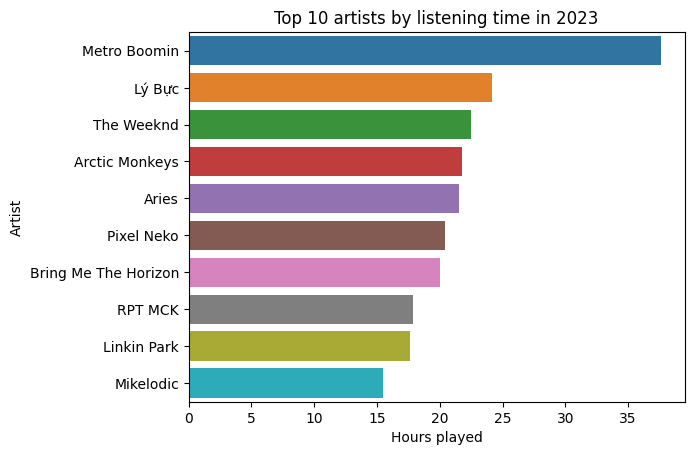

In [89]:
music_df_2023 = music_df[music_df['datetime'].apply(lambda t:t.year == 2023)]
music_df_2023 = music_df_2023.groupby('master_metadata_album_artist_name')['hours_played'].sum()
music_df_2023 = music_df_2023.sort_values(ascending=False).head(10)
music_df_2023 = music_df_2023.reset_index()
music_df_2023

sns.barplot(
    data=music_df_2023,
    x=music_df_2023.hours_played,
    y=music_df_2023.master_metadata_album_artist_name,
    orient='h'
)
plt.xlabel('Hours played')
plt.ylabel('Artist')
plt.title('Top 10 artists by listening time in 2023')



## Question 1: With the data from 2020 to 2023, I would like to find out top 10 artists I listened to during each year (similar to a Spotify Wrapped)

In [90]:
def top_10_listening_time(year):
    music_df_plot = music_df[music_df['datetime'].apply(lambda t:t.year == year)]
    music_df_plot = music_df_plot.groupby('master_metadata_album_artist_name')['hours_played'].sum()
    music_df_plot = music_df_plot.sort_values(ascending=False).head(10)
    music_df_plot = music_df_plot.reset_index()
    music_df_plot

    sns.barplot(
        data=music_df_plot,
        x=music_df_plot.hours_played,
        y=music_df_plot.master_metadata_album_artist_name,
        orient='h'
    )
    plt.xlabel('Hours played')
    plt.ylabel('Artist')
    plt.title('Top 10 artists by listening time in ' + str(year))



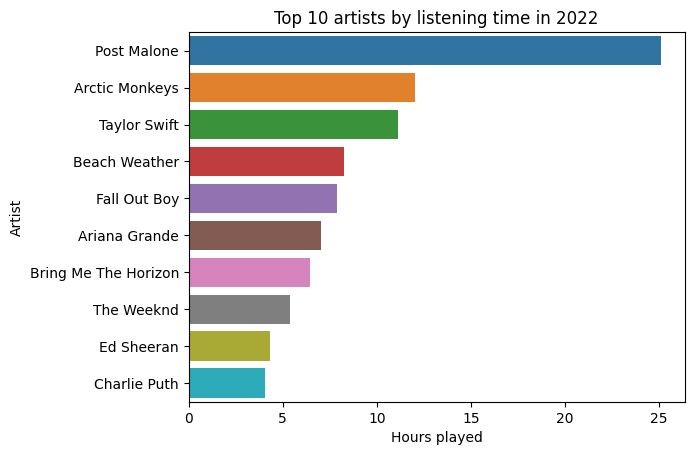

In [91]:
top_10_listening_time(2022)

# Question 2 - What were my favorite songs during those years?

In [164]:
music_df_truncated = music_df[['master_metadata_track_name', 'master_metadata_album_artist_name','master_metadata_album_album_name', 'hours_played', 'datetime']]
# Perform lambda function to group by year
def favorite_10_songs(year):
    music_df_truncated_by_year = music_df_truncated[music_df_truncated['datetime'].apply(lambda t:t.year == year)]
    music_df_truncated_by_year = music_df_truncated_by_year.groupby(by=['master_metadata_track_name','master_metadata_album_artist_name']).sum('hours_played')
    music_df_truncated_by_year = music_df_truncated_by_year.sort_values('hours_played',ascending=False)[:10]
    return music_df_truncated_by_year

In [93]:
favorite_10_songs(2020)

,,hours_played
master_metadata_track_name,master_metadata_album_artist_name,
Re:Re: (Single ver.),ASIAN KUNG-FU GENERATION,5.504844
Re:Re:,ASIAN KUNG-FU GENERATION,4.579546
Open Door,Mike Shinoda,2.669939
WHAT YOU GONNA DO???,Bastille,2.279169
Bad Decisions,Bastille,1.974452
Quarter Past Midnight,Bastille,1.642454
星の奏でる歌 - Duet Ver.,椎名まゆり(cv.花澤香菜),1.597579
Doom Days,Bastille,1.517034
リライト,ASIAN KUNG-FU GENERATION,1.455168


# Question 3 - How much did I enjoy listening to an artist over time?

In [94]:
# Determine top artists listened to.
top_artists_df = music_df.groupby(['master_metadata_album_artist_name'])[['hours_played']]
top_artists_df = top_artists_df.sum().sort_values('hours_played', ascending=False)[:5]
top_artists = [artist for (artist) in top_artists_df.index.values]

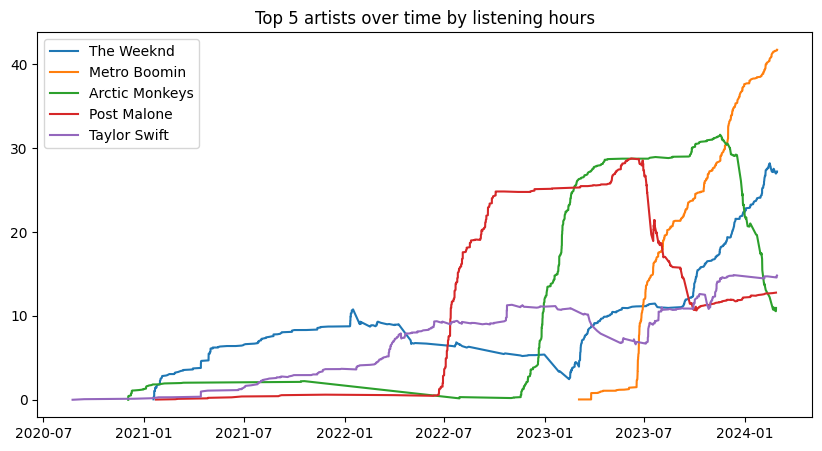

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))
for artist in top_artists:
  # Generate rolling sums of total amount of time listening to the artist.
  favorite_artist_over_time = music_df.loc[music_df['master_metadata_album_artist_name'] == artist][['datetime', 'hours_played']]
  favorite_artist_over_time = favorite_artist_over_time.sort_values('datetime')
  favorite_artist_over_time = favorite_artist_over_time.rolling('365D', on='datetime').sum()
  ax.plot(favorite_artist_over_time['datetime'], favorite_artist_over_time['hours_played'], label=artist)

ax.set_title('Top 5 artists over time by listening hours')
plt.legend()
plt.show()

# Question 4: Daily listening habit per year - Do I still use Spotify that much?

Data needed for this question: Hours played & Datetime

In [160]:
listening_habit = music_df[['datetime', 'hours_played']].copy()
listening_habit['year'] = listening_habit['datetime'].apply(lambda t:t.year)
listening_habit['month'] = listening_habit['datetime'].dt.month
listening_habit['year-month'] = listening_habit['datetime'].dt.strftime('%Y%m')
listening_habit.head(10)

,datetime,hours_played,year,month,year-month
0,2020-08-22 16:34:56+00:00,0.066211,2020,8,202008
1,2020-08-22 16:40:32+00:00,0.002636,2020,8,202008
2,2020-08-22 16:40:42+00:00,0.000694,2020,8,202008
3,2020-08-22 16:40:45+00:00,0.000861,2020,8,202008
4,2020-08-22 16:40:52+00:00,0.001828,2020,8,202008
5,2020-08-22 16:40:55+00:00,0.000914,2020,8,202008
6,2020-08-22 16:41:03+00:00,0.002233,2020,8,202008
7,2020-08-22 16:41:51+00:00,0.008056,2020,8,202008
8,2020-08-22 16:44:55+00:00,0.051264,2020,8,202008
9,2020-08-22 16:45:47+00:00,0.015602,2020,8,202008


<BarContainer object of 44 artists>

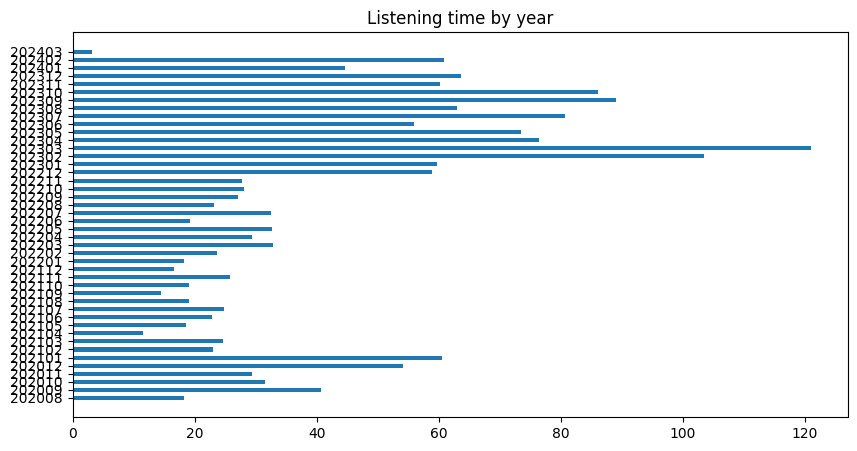

In [162]:
listening_time = listening_habit.groupby('year-month')['hours_played'].sum()
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Listening time by year')
ax.barh(listening_time.index, listening_time, height=0.5)
# ax.set_yticklabels(labels=listening_time.index, fontsize=8)
# ax.yaxis.set_tick_params(pad=10)

# Question 5 - Favorite album per year & Favorite album of all time

In [203]:
# album_df = music_df[['master_metadata_track_name', 'master_metadata_album_artist_name','master_metadata_album_album_name', 'hours_played', 'datetime']]
# # Perform lambda function to group by year
# def favorite_albums(year):
#     favorite_albums_by_year = album_df[album_df['datetime'].apply(lambda t:t.year == year)]
#     favorite_albums_by_year = album_df.groupby(by=['master_metadata_track_name','master_metadata_album_artist_name']).sum('hours_played')
#     favorite_albums_by_year = album_df.sort_values('hours_played',ascending=False)[:10]
#     # Clean singles
#     favorite_albums_by_year = favorite_albums_by_year.dropna(subset='master_metadata_album_album_name')
#     return favorite_albums_by_year

Favorite album of all time from the beginning of my Spotify usage

In [210]:
album_listen_time = music_df.groupby('master_metadata_album_album_name').sum('hours_played')
# album_listen_time = album_listen_time.groupby(by=['master_metadata_track_name','master_metadata_album_artist_name']).sum('hours_played')
album_listen_time = album_listen_time.sort_values('hours_played', ascending=False)
album_listen_time[['hours_played']][:10]

,hours_played
master_metadata_album_album_name,
METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE SPIDER-VERSE,38.284302
Đánh Đổi,19.655421
99%,19.605334
That's The Spirit,17.760666
Starboy,15.973147
Favourite Worst Nightmare,15.760804
"BELIEVE IN ME, WHO BELIEVES IN YOU",12.379643
After Hours,11.760253
AM,11.271136


# Question 6 - Time of the day that I listened on Spotify the most